# CUHK [STAT3009](https://www.bendai.org/STAT3009/) Notebook7: Real Application

## load the developed methods

In [2]:
def rmse(true, pred):
	return np.sqrt(np.mean((pred - true)**2))

# baseline methods
class glb_mean(object):
	def __init__(self):
		self.glb_mean = 0
	
	def fit(self, train_ratings):
		self.glb_mean = np.mean(train_ratings)
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))
		pred = pred*self.glb_mean
		return pred

class user_mean(object):
	def __init__(self, n_user):
		self.n_user = n_user
		self.glb_mean = 0.
		self.user_mean = np.zeros(n_user)
	
	def fit(self, train_pair, train_ratings):
		self.glb_mean = train_ratings.mean()
		for u in range(self.n_user):
			ind_train = np.where(train_pair[:,0] == u)[0]
			if len(ind_train) == 0:
				self.user_mean[u] = self.glb_mean
			else:
				self.user_mean[u] = train_ratings[ind_train].mean()
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.user_mean[user_tmp]
			j = j + 1
		return pred

class item_mean(object):
	def __init__(self, n_item):
		self.n_item = n_item
		self.glb_mean = 0.
		self.item_mean = np.zeros(n_item)
	
	def fit(self, train_pair, train_ratings):
		self.glb_mean = train_ratings.mean()
		for i in range(self.n_item):
			ind_train = np.where(train_pair[:,1] == i)[0]
			if len(ind_train) == 0:
				self.item_mean[i] = self.glb_mean
			else:
				self.item_mean[i] = train_ratings[ind_train].mean()
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.item_mean[item_tmp]
			j = j + 1
		return pred


class LFM(object):

    def __init__(self, n_user, n_item, lam=.001, K=10, iterNum=10, tol=1e-4, verbose=1):
        self.P = np.random.randn(n_user, K)
        self.Q = np.random.randn(n_item, K)
        # self.index_item = []
        # self.index_user = []
        self.n_user = n_user
        self.n_item = n_item
        self.lam = lam
        self.K = K
        self.iterNum = iterNum
        self.tol = tol
        self.verbose = verbose

    def fit(self, train_pair, train_rating):
        diff, tol = 1., self.tol
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        ## store user/item index set
        self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
        self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
        if self.verbose:
            print('Fitting Reg-LFM: K: %d, lam: %.5f' %(K, lam))
        for i in range(iterNum):
            ## item update
            score_old = self.rmse(test_pair=train_pair, test_rating=train_rating)
            for item_id in range(n_item):
                index_item_tmp = self.index_item[item_id]
                if len(index_item_tmp) == 0:
                    self.Q[item_id,:] = 0.
                    continue
                sum_pu, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_item_tmp:
                    ## double-check
                    if item_id != train_pair[record_ind][1]:
                        raise ValueError('the item_id is waring in updating Q!')
                    user_id, rating_tmp = train_pair[record_ind][0], train_rating[record_ind]
                    sum_matrix = sum_matrix + np.outer(self.P[user_id,:], self.P[user_id,:])
                    sum_pu = sum_pu + rating_tmp * self.P[user_id,:]                    
                self.Q[item_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_pu)
            
            for user_id in range(n_user):
                index_user_tmp = self.index_user[user_id]
                if len(index_user_tmp) == 0:
                    self.P[user_id,:] = 0.
                    continue
                sum_pu, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_user_tmp:
                    ## double-check
                    if user_id != train_pair[record_ind][0]:
                        raise ValueError('the user_id is waring in updating P!')
                    item_id, rating_tmp = train_pair[record_ind][1], train_rating[record_ind]
                    sum_matrix = sum_matrix + np.outer(self.Q[item_id,:], self.Q[item_id,:])
                    sum_pu = sum_pu + rating_tmp * self.Q[item_id,:]                    
                self.P[user_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_pu)
            # compute the new rmse score
            score_new = self.rmse(test_pair=train_pair, test_rating=train_rating)
            diff = abs(score_new - score_old) / score_old
            if self.verbose:
                print("Reg-LFM: ite: %d; diff: %.3f RMSE: %.3f" %(i, diff, score_new))
            if(diff < tol):
                break

    def predict(self, test_pair):
        # predict ratings for user-item pairs
        pred_rating = [np.dot(self.P[line[0]], self.Q[line[1]]) for line in test_pair]
        return np.array(pred_rating)
    
    def rmse(self, test_pair, test_rating):
        # report the rmse for the fitted `LFM`
        pred_rating = self.predict(test_pair=test_pair)
        return np.sqrt( np.mean( (pred_rating - test_rating)**2) )

from sklearn.model_selection import KFold
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class LFM_CV(object):

	def __init__(self, n_user, n_item, cv=5,
				lams=[.000001,.0001,.001,.01], 
				Ks=[3,5,10,20], 
				iterNum=10, tol=1e-4):
		# self.index_item = []
		# self.index_user = []
		self.n_user = n_user
		self.n_item = n_item
		self.cv = cv
		self.lams = lams
		self.Ks = Ks
		self.iterNum = iterNum
		self.tol = tol
		self.best_model = {}
		self.cv_result = {'K': [], 'lam': [], 'train_rmse': [], 'valid_rmse': []}

	def grid_search(self, train_pair, train_rating):
		## generate all comb of `K` and `lam`
		kf = KFold(n_splits=self.cv, shuffle=True)
		for (K,lam) in itertools.product(self.Ks, self.lams):
			train_rmse_tmp, valid_rmse_tmp = 0., 0.
			for train_index, valid_index in kf.split(train_pair):
				# produce training/validation sets
				train_pair_cv, train_rating_cv = train_pair[train_index], train_rating[train_index]
				valid_pair_cv, valid_rating_cv = train_pair[valid_index], train_rating[valid_index]
				# fit the model based on CV data
				model_tmp = LFM(self.n_user, self.n_item, K=K, lam=lam, verbose=0)
				model_tmp.fit(train_pair=train_pair_cv, train_rating=train_rating_cv)
				train_rmse_tmp_cv = model_tmp.rmse(test_pair=train_pair_cv, test_rating=train_rating_cv)
				valid_rmse_tmp_cv = model_tmp.rmse(test_pair=valid_pair_cv, test_rating=valid_rating_cv)
				train_rmse_tmp = train_rmse_tmp + train_rmse_tmp_cv / self.cv
				valid_rmse_tmp = valid_rmse_tmp + valid_rmse_tmp_cv / self.cv
				print('%d-Fold CV for K: %d; lam: %.5f: train_rmse: %.3f, valid_rmse: %.3f' 
						%(self.cv, K, lam, train_rmse_tmp_cv, valid_rmse_tmp_cv))
			self.cv_result['K'].append(K)
			self.cv_result['lam'].append(lam)
			self.cv_result['train_rmse'].append(train_rmse_tmp)
			self.cv_result['valid_rmse'].append(valid_rmse_tmp)
		self.cv_result = pd.DataFrame.from_dict(self.cv_result)
		best_ind = self.cv_result['valid_rmse'].argmin()
		self.best_model = self.cv_result.loc[best_ind]
	
	def plot_grid(self, data_source='valid'):
		sns.set_theme()
		if data_source == 'train':
			cv_pivot = self.cv_result.pivot("K", "lam", "train_rmse")
		elif data_source == 'valid':
			cv_pivot = self.cv_result.pivot("K", "lam", "valid_rmse")
		else:
			raise ValueError('data_source must be train or valid!')
		sns.heatmap(cv_pivot, annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
		plt.show()

ModuleNotFoundError: No module named 'seaborn'

## Pre-process the ML-100K raw data
- check the `user_id` and `item_id`: mapping `item_id` to a continuous sequence based on `sklean.preprocessing`
- use `sklearn.model_selection.train_test_split` to generate `train` and `test` dataset
- create `train_pair`,`train_rating`, `test_pair`

In [3]:
import numpy as np
import pandas as pd

df = pd.read_csv('./dataset/ml-latest-small/ratings.csv')
del df['timestamp']
## mapping 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['movieId'] = le.fit_transform(df['movieId'])
df['userId'] = le.fit_transform(df['userId'])
## generate train / test dataset
from sklearn.model_selection import train_test_split
dtrain, dtest = train_test_split(df, test_size=0.33, random_state=42)
## save real ratings for test set for evaluation.
test_rating = np.array(dtest['rating'])
## remove the ratings in the test set to simulate prediction
dtest = dtest.drop(columns='rating')

## Exploratory data analysis (EDA)
- User rating of the movie

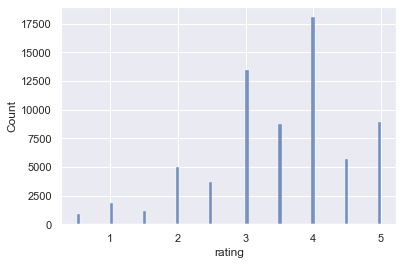

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
## histograms of rating 
sns.histplot(data=dtrain, x="rating")
plt.show()

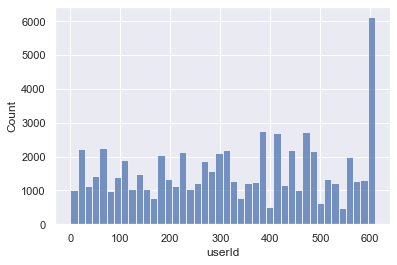

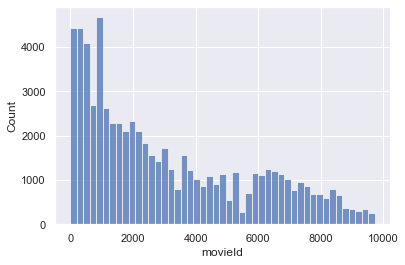

In [5]:
## histograms of user 
sns.histplot(data=dtrain, x="userId")
plt.show()
## histograms of item 
sns.histplot(data=dtrain, x="movieId")
plt.show()

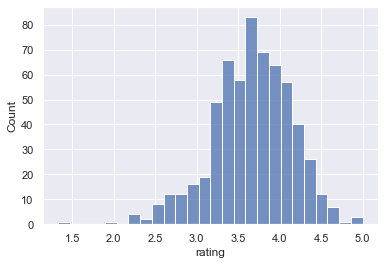

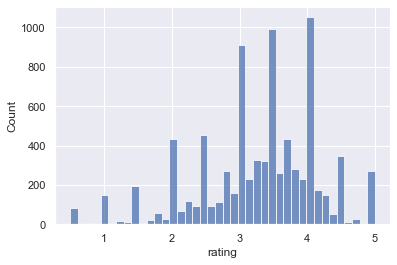

In [6]:
# histgrams for averaged ratings for users/items
sns.histplot(dtrain.groupby('userId')['rating'].mean())
plt.show()
sns.histplot(dtrain.groupby('movieId')['rating'].mean())
plt.show()

In [7]:
## Find Top-20 highest rating movies 
dtrain.groupby('movieId')['rating'].mean().sort_values(ascending = False)[:20]

movieId
7561    5.0
9132    5.0
6309    5.0
7383    5.0
9122    5.0
9123    5.0
9124    5.0
9126    5.0
9134    5.0
3686    5.0
7030    5.0
8258    5.0
8709    5.0
1036    5.0
2327    5.0
3729    5.0
5277    5.0
7534    5.0
7117    5.0
6478    5.0
Name: rating, dtype: float64

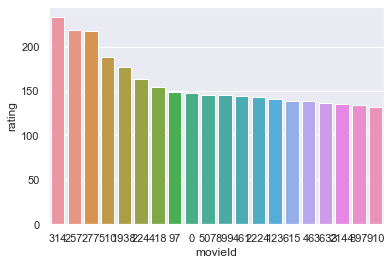

In [8]:
## Find Top-20 most popular movies 
dtmp = dtrain.groupby('movieId')['rating'].count().sort_values(ascending = False)[:20]
sns.barplot(x=dtmp.index, y=dtmp, order=dtmp.index)
plt.show()

In [9]:
# tran_pair, train_rating
train_pair = dtrain[['userId', 'movieId']].values
train_rating = dtrain['rating'].values
# test_pair
test_pair = dtest[['userId', 'movieId']].values
n_user, n_item = max(train_pair[:,0].max(), test_pair[:,0].max())+1, max(train_pair[:,1].max(), test_pair[:,1].max())+1

## Use the developed methods to predict ratings

In [14]:
## Baseline
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred_glb = glb_ave.predict(test_pair)
print('RSME for gbl mean: %.3f' %rmse(test_rating, pred_glb))

RSME for gbl mean: 1.045


In [17]:
# user_mean
train_rating_cm = train_rating - glb_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
pred_user_mean = pred_glb + user_ave.predict(test_pair)
print('RSME for user-mean: %.3f' %rmse(test_rating, pred_user_mean))

RSME for user-mean: 0.946


In [18]:
## item mean
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
pred_item_mean = pred_glb + item_ave.predict(test_pair)
print('RSME for item-mean: %.3f' %rmse(test_rating, pred_item_mean))

RSME for item-mean: 0.987


3-Fold CV for K: 2; lam: 0.00000: train_rmse: 0.706, valid_rmse: 1.157
3-Fold CV for K: 2; lam: 0.00000: train_rmse: 0.696, valid_rmse: 1.163
3-Fold CV for K: 2; lam: 0.00000: train_rmse: 0.720, valid_rmse: 1.233
3-Fold CV for K: 2; lam: 0.00000: train_rmse: 0.691, valid_rmse: 1.027
3-Fold CV for K: 2; lam: 0.00000: train_rmse: 0.678, valid_rmse: 1.028
3-Fold CV for K: 2; lam: 0.00000: train_rmse: 0.733, valid_rmse: 1.152
3-Fold CV for K: 2; lam: 0.00001: train_rmse: 0.685, valid_rmse: 0.968
3-Fold CV for K: 2; lam: 0.00001: train_rmse: 0.675, valid_rmse: 0.960
3-Fold CV for K: 2; lam: 0.00001: train_rmse: 0.677, valid_rmse: 0.957
3-Fold CV for K: 2; lam: 0.00003: train_rmse: 0.697, valid_rmse: 0.930
3-Fold CV for K: 2; lam: 0.00003: train_rmse: 0.694, valid_rmse: 0.930
3-Fold CV for K: 2; lam: 0.00003: train_rmse: 0.696, valid_rmse: 0.925
3-Fold CV for K: 2; lam: 0.00010: train_rmse: 0.744, valid_rmse: 0.887
3-Fold CV for K: 2; lam: 0.00010: train_rmse: 0.739, valid_rmse: 0.896
3-Fold

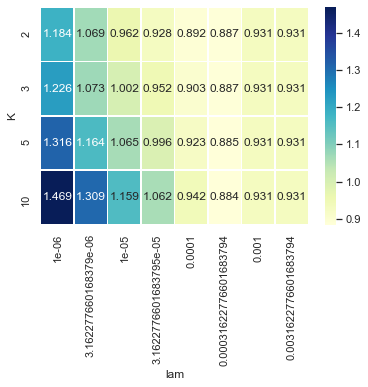

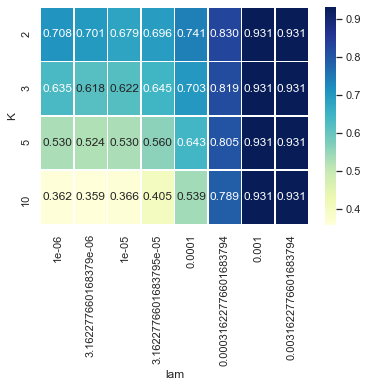

In [21]:
# fit user_mean + LFM_CV by residual ratings 
train_rating_res = train_rating_cm - user_ave.predict(train_pair)

Ks, lams = [2, 3, 5, 10], 10**np.arange(-6, -2, .5)
shiing_cv = LFM_CV(n_user, n_item, cv=3, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

In [31]:
## refit the best model with the full dataset
print(shiing_cv.best_model)
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing_best = LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing_best.fit(train_pair, train_rating_res)
pred_LFM = pred_user_mean + shiing_best.predict(test_pair)
print('RMSE for user_mean + LFM: %.3f' %rmse(test_rating, pred_LFM))

K             10.000000
lam            0.000316
train_rmse     0.788936
valid_rmse     0.884190
Name: 29, dtype: float64
Fitting Reg-LFM: K: 10, lam: 0.00032
Reg-LFM: ite: 0; diff: 0.736 RMSE: 0.875
Reg-LFM: ite: 1; diff: 0.027 RMSE: 0.851
Reg-LFM: ite: 2; diff: 0.018 RMSE: 0.836
Reg-LFM: ite: 3; diff: 0.003 RMSE: 0.833
Reg-LFM: ite: 4; diff: 0.001 RMSE: 0.832
Reg-LFM: ite: 5; diff: 0.001 RMSE: 0.831
Reg-LFM: ite: 6; diff: 0.001 RMSE: 0.831
Reg-LFM: ite: 7; diff: 0.001 RMSE: 0.830
Reg-LFM: ite: 8; diff: 0.001 RMSE: 0.829
Reg-LFM: ite: 9; diff: 0.001 RMSE: 0.829
RMSE for user_mean + LFM: 0.894


## How to use the existing Python package ([Surprise](http://surpriselib.com/)) to make prediction in recommender systems

### Installation via `pip`
```console
$ pip install scikit-surprise
```
### Installation via `conda`
```console
$ conda install -c conda-forge scikit-surprise
```
### Implementation
	- Load package and data
	- Convert the data to be type that `suprise` could understand
	- Determine which method you want to use

In [1]:
## Step 1: Load package and data
import numpy as np
import pandas as pd

df = pd.read_csv('./dataset/ml-latest-small/ratings.csv')
del df['timestamp']
## mapping 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['movieId'] = le.fit_transform(df['movieId'])
df['userId'] = le.fit_transform(df['userId'])
## generate train / test dataset
from sklearn.model_selection import train_test_split
dtrain, dtest = train_test_split(df, test_size=0.33, random_state=42)
## save real ratings for test set for evaluation.
test_rating = np.array(dtest['rating'])
## remove the ratings in the test set to simulate prediction
dtest = dtest.drop(columns='rating')

## Step 2: Convert the data to be type that `suprise` could understand
# via `reader` in `surprise`
from surprise import Reader
from surprise import Dataset
# rating_scale is required
reader = Reader(rating_scale=(0.5, 5.0))
## this auto-folds dataset
surp_train_AF = Dataset.load_from_df(dtrain[['userId', 'movieId', 'rating']], reader)
## this is trainset dataset
surp_train = surp_train_AF.build_full_trainset()

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [11]:
## `surprise` has an issue to cold-start problem when make prediction
# define a prediction function to exclude the cold-start users/items
def surp_pred(dtest, dtrain, method, cold_start=True):
	gbl_mean = dtrain['rating'].mean()
	user_lst, item_lst = list(set(dtrain['userId'])), list(set(dtrain['movieId']))
	surp_pred_lst = []
	for _, row in dtest.iterrows():
		user_id, item_id = row['userId'], row['movieId']
		if cold_start:
			rating_tmp = method.estimate(user_id, item_id)
		else:
			if ((row['userId'] in user_lst) and (row['movieId'] in item_lst)):
				rating_tmp = method.estimate(user_id, item_id)
			else:
				rating_tmp = gbl_mean
		surp_pred_lst.append(rating_tmp)
	surp_pred_lst = np.array(surp_pred_lst)
	return surp_pred_lst

In [5]:
## Step 3: determine the method you want to use
# algo 1: baseline
from surprise.prediction_algorithms.baseline_only import BaselineOnly
from surprise.model_selection import cross_validate
algo1 = BaselineOnly()
# fit model
algo1.fit(surp_train)
pred_baseline = surp_pred(dtest, dtrain, algo1)
print('RSME for surprise-baseline: %.3f' %rmse(test_rating, pred_baseline))

Estimating biases using als...
RSME for surprise-baseline: 1.114


In [8]:
# algo 2: SVD model
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import GridSearchCV
## GS based on CV
param_grid = {'reg_all': 10**np.arange(-4, -2, .5), 'n_factors': [2, 3, 5, 10]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(surp_train_AF)
# cv result 
results_df = pd.DataFrame.from_dict(gs.cv_results)
print(results_df)
# best RMSE score
print('best RMSE score: %.3f' %gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print('best hyperparam: %s' %gs.best_params['rmse'])
# We can now use the algorithm that yields the best rmse:
algo2_best = gs.best_estimator['rmse']
algo2_best.fit(surp_train)
# make prediction
pred_svd = surp_pred(dtest, dtrain, algo2_best)
print('RSME for surprise-svd-best: %.3f' %rmse(test_rating, pred_svd))

    split0_test_rmse  split1_test_rmse  split2_test_rmse  mean_test_rmse  \
0           0.885570          0.879980          0.881535        0.882362   
1           0.885386          0.880053          0.881267        0.882236   
2           0.886351          0.881808          0.883732        0.883964   
3           0.888501          0.881690          0.884495        0.884895   
4           0.886044          0.879276          0.881215        0.882179   
5           0.886668          0.880120          0.882028        0.882939   
6           0.886257          0.880413          0.883666        0.883445   
7           0.887919          0.882667          0.883158        0.884581   
8           0.885738          0.879481          0.881751        0.882323   
9           0.885912          0.880183          0.882080        0.882725   
10          0.886640          0.881612          0.882524        0.883592   
11          0.888035          0.882238          0.882387        0.884220   
12          

## More models: `CoClustering` and `SVDpp`(Homework)

In [12]:
# algo 3: Co-clustering model
from surprise.prediction_algorithms.matrix_factorization import SVD, SVDpp
from surprise.prediction_algorithms.co_clustering import CoClustering
## GS based on CV
param_grid = {'n_cltr_u': [2, 3, 5, 10], 'n_cltr_i': [2, 3, 5, 10]}
gs = GridSearchCV(CoClustering, param_grid, measures=['rmse'], cv=3)
gs.fit(surp_train_AF)
# cv result 
results_df = pd.DataFrame.from_dict(gs.cv_results)
print(results_df)
# best RMSE score
print('best RMSE score: %.3f' %gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print('best hyperparam: %s' %gs.best_params['rmse'])
# We can now use the algorithm that yields the best rmse:
algo3_best = gs.best_estimator['rmse']
algo3_best.fit(surp_train)
# make prediction
pred_coc = surp_pred(dtest, dtrain, algo3_best)
print('RSME for surprise-svd: %.3f' %rmse(test_rating, pred_coc))

    split0_test_rmse  split1_test_rmse  split2_test_rmse  mean_test_rmse  \
0           0.958307          0.971918          0.966453        0.965559   
1           0.958515          0.972774          0.966407        0.965899   
2           0.962125          0.972931          0.966154        0.967070   
3           0.960948          0.974925          0.969479        0.968451   
4           0.961703          0.973350          0.967765        0.967606   
5           0.967434          0.976966          0.971585        0.971995   
6           0.970436          0.980488          0.975335        0.975419   
7           0.968342          0.983130          0.978493        0.976655   
8           0.960703          0.972776          0.965958        0.966479   
9           0.967258          0.977812          0.973544        0.972871   
10          0.972650          0.985578          0.978612        0.978947   
11          0.980898          0.991958          0.985166        0.986007   
12          

<ipython-input-12-f4c4bf03bb93>:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo3_best.fit(surp_train)


RSME for surprise-svd: 1.431


## We still suffer from cold-start issue, in the following lectures we will provide more methods to solve this issue.